<a href="https://colab.research.google.com/github/josedv82/airball/blob/master/NBA_Schedule_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**XGBOOST PLAYGROUND**


---


**Game Outcome Prediction Model using XGboost via h2o**    
Jose Fernandez

This notebook aims to serve as an example of how {airball package} data could be utilized. If you have ideas on how to improve the below example please get in touch.

In [ ]:
#install required packages
install.packages(c("tidyverse", "h2o"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#load libraries and data
library(tidyverse)
library(h2o)

dat <- read.csv("/data.csv") %>%
mutate(Result = ifelse(Result == "W", 1, 0)) %>%
mutate(Result = as.factor(Result)) %>% select(-X)
head(dat)

#for more info on how this data was collected visit: https://github.com/josedv82/airball

,Location,Distance,Rest,Zone,Result,win_pct
,<int>,<int>,<int>,<int>,<fct>,<dbl>
1,1,544,1,0,0,0.00
2,1,0,1,0,1,0.33
3,2,1203,1,-2,0,0.25
4,2,1110,1,-1,0,0.20
5,2,259,2,0,0,0.17
6,2,821,0,0,0,0.14


In [ ]:
#set target and features
target <- "Result"
features <- setdiff(colnames(dat), target)
print(features)

[1] "Location" "Distance" "Rest"     "Zone"     "win_pct" 


In [ ]:
#start h2o cluster
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 29 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    5 months and 22 days !!! 
    H2O cluster name:           H2O_started_from_R_root_ebq901 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.96 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.4 (2021-02-15) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (5 months and 22 days)!
Please download and install the latest version from http://h2o.ai/download/”


In [ ]:
#convert our df into a h2o df
h_data <- as.h2o(dat)
# split 75/25 train & validation dataset
h_split <- h2o.splitFrame(h_data, ratios = 0.75, seed = 42)
h_train <- h_split[[1]]
h_test <- h_split[[2]]

  |======================================================================| 100%


In [ ]:
# Build and train the xgboost model. Parameters are almost default for everything. 
mod_xgb <- h2o.xgboost(x = features, y = target,
                           training_frame = h_train, 
                           validation_frame = h_test,
                           booster = "gbtree", 
                           normalize_type = "tree", 
                           eta = 0.3, 
                           max_depth = 8, 
                           gamma = 4, 
                           subsample = 0.5, 
                           colsample_bytree = 0.5,
                           seed = 42)

  |====================| 100%


1.5
3.5
5.5
7.5
9.5


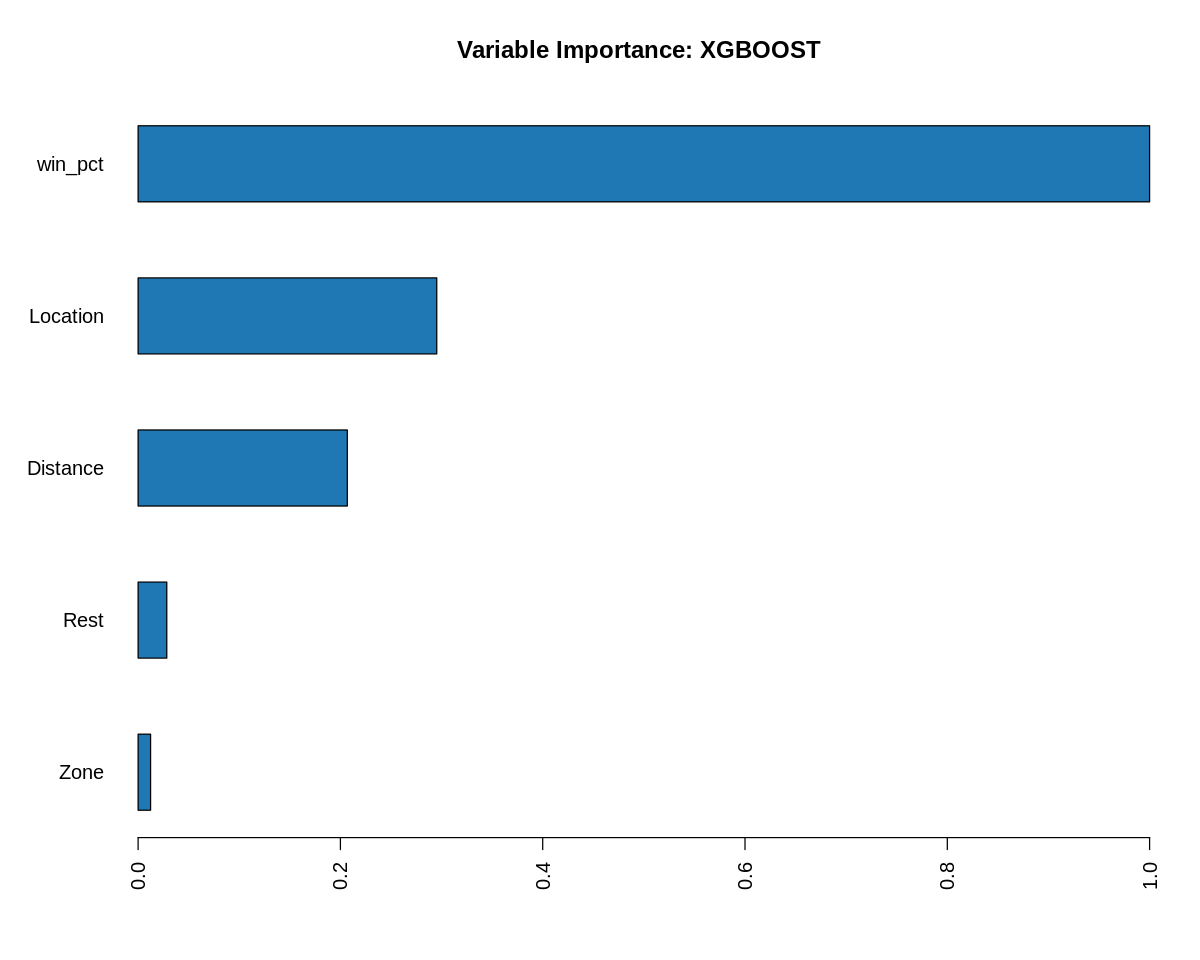

In [ ]:
#variable importance
plot <- h2o.varimp_plot(mod_xgb, num_of_features = 5)
plot

In [ ]:
# Confusion matrix
perf <- h2o.performance(mod_xgb, h_test)
h2o.confusionMatrix(perf)

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,2189,4252,0.6601459,=4252/6441
1,659,5640,0.1046198,=659/6299
Totals,2848,9892,0.3854788,=4911/12740


In [ ]:
# Generate predictions on the test set:
pred <- h2o.predict(mod_xgb, newdata = h_test)
pred

#summary of the prediction with a probability of W (1)
summary(pred$p1, exact_quantiles = TRUE)

  |====================| 100%


  predict        p0        p1
1       0 0.7586034 0.2413966
2       1 0.5885928 0.4114072
3       1 0.4941011 0.5058989
4       1 0.4434884 0.5565116
5       0 0.6724025 0.3275975
6       0 0.6970482 0.3029518

[12740 rows x 3 columns] 

 p1                
 Min.   :0.004071  
 1st Qu.:0.355318  
 Median :0.504061  
 Mean   :0.504782  
 3rd Qu.:0.654838  
 Max.   :0.991209  

In [ ]:
#model accuracy
h2o.accuracy(perf)

[1] "AUC"


[1] 0.73

[1] "plot"


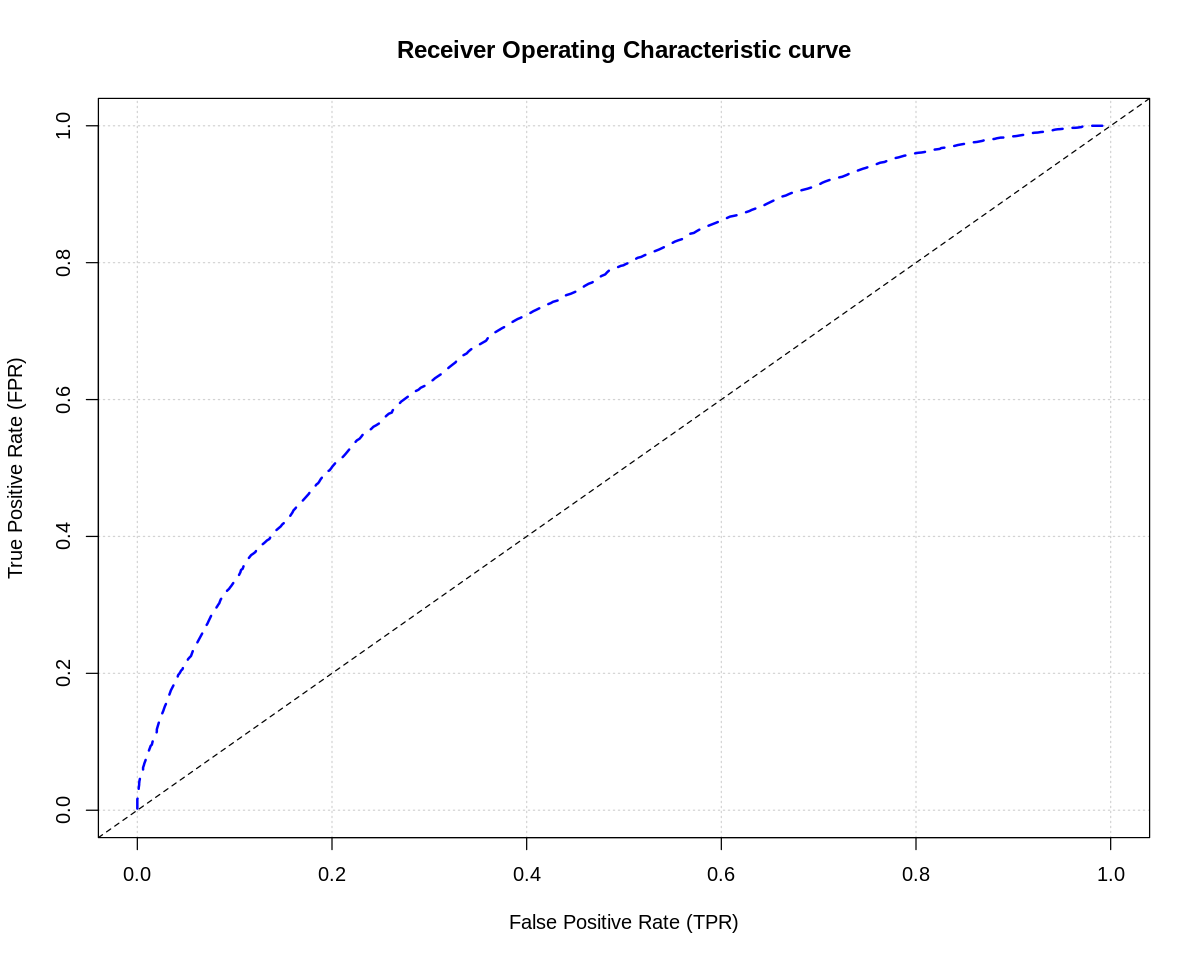

In [ ]:
# retrieve the AUC for the performance object:
print("AUC")
round(h2o.auc(perf),2)
print("plot")
plot(perf, type = "roc")

In [ ]:
# retrieve the AUC for both the training and validation data:
round(h2o.auc(mod_xgb, train = TRUE, valid = TRUE, xval = FALSE),2)

train valid 
 0.74  0.73

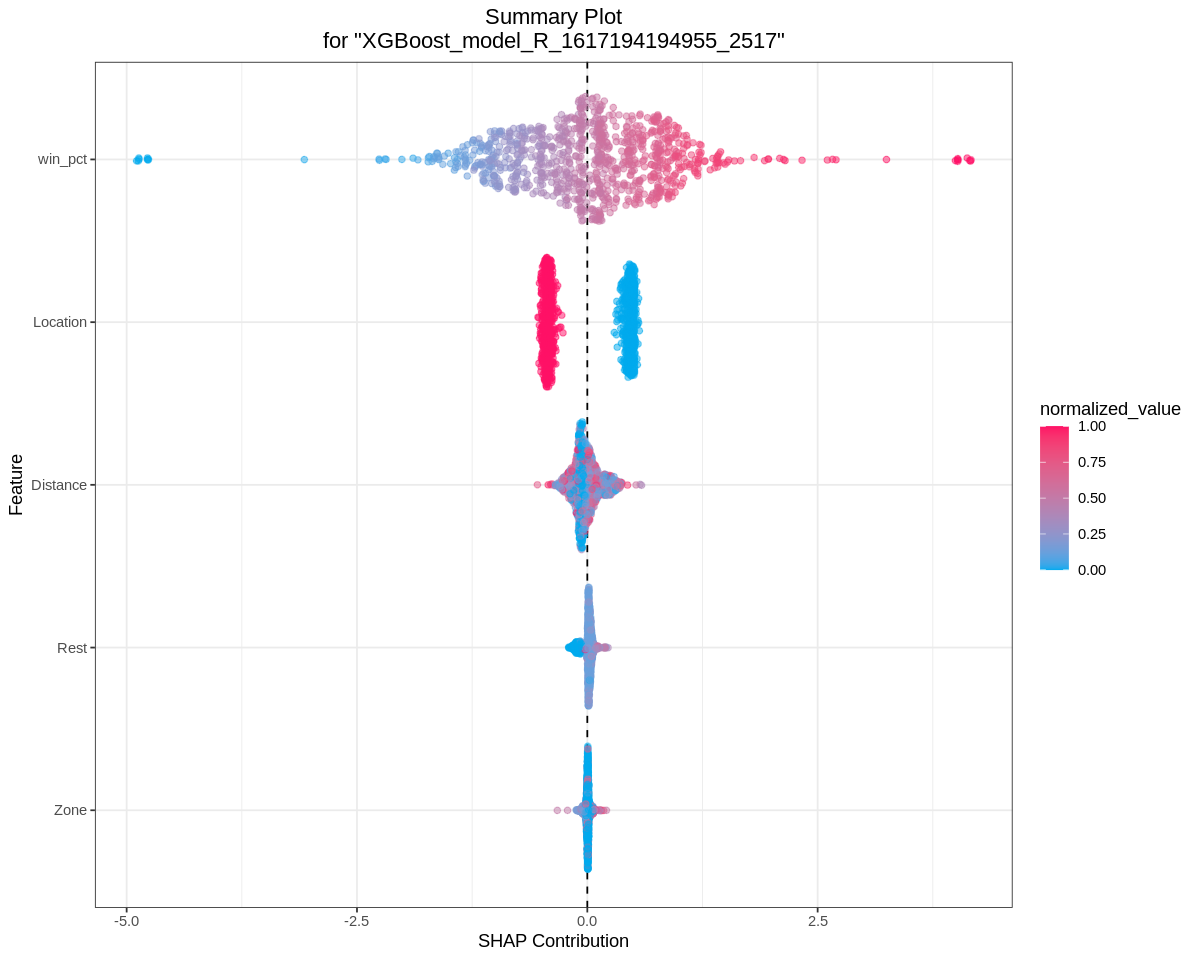

In [ ]:
#shap explanation for the model. at the top more important features. Pink colors contrinute to winning
shap_summary_plot <- h2o.shap_summary_plot(mod_xgb, h_test)
print(shap_summary_plot)

For Jupyter installing plotly, htmltools, and DT is recommended.



SHAP explanation

SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

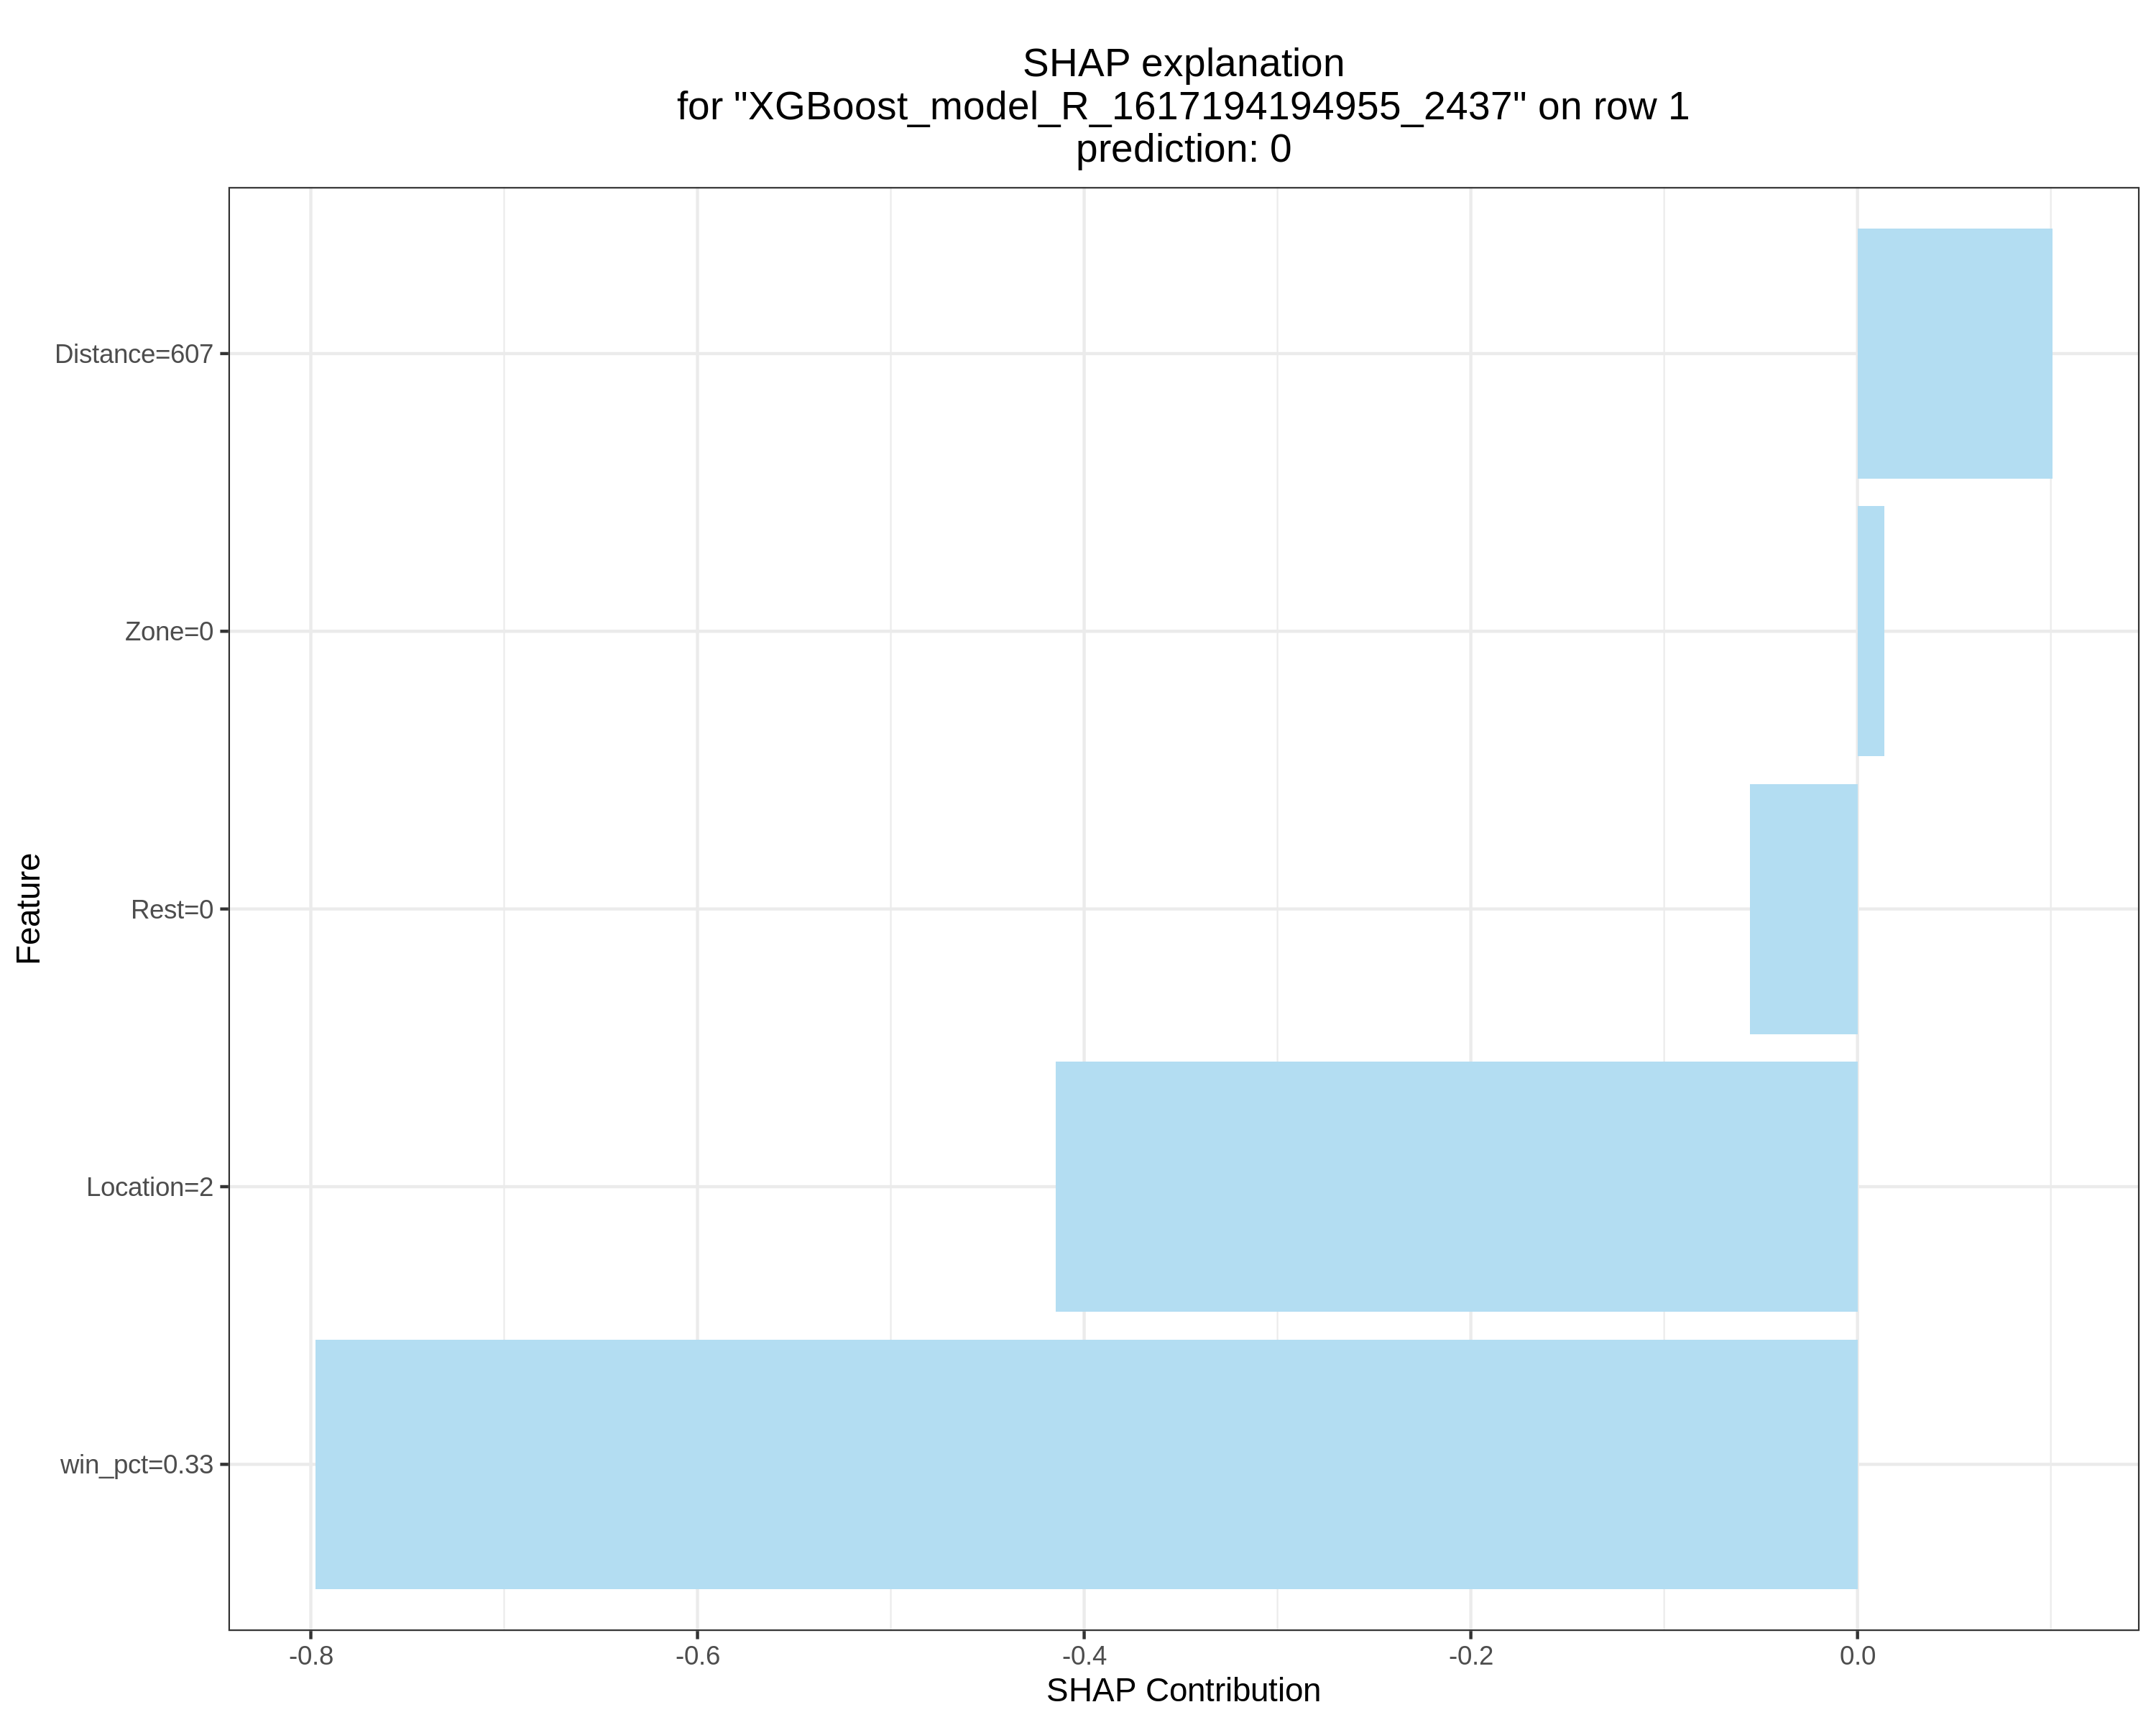

Individual Conditional Expectations

Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

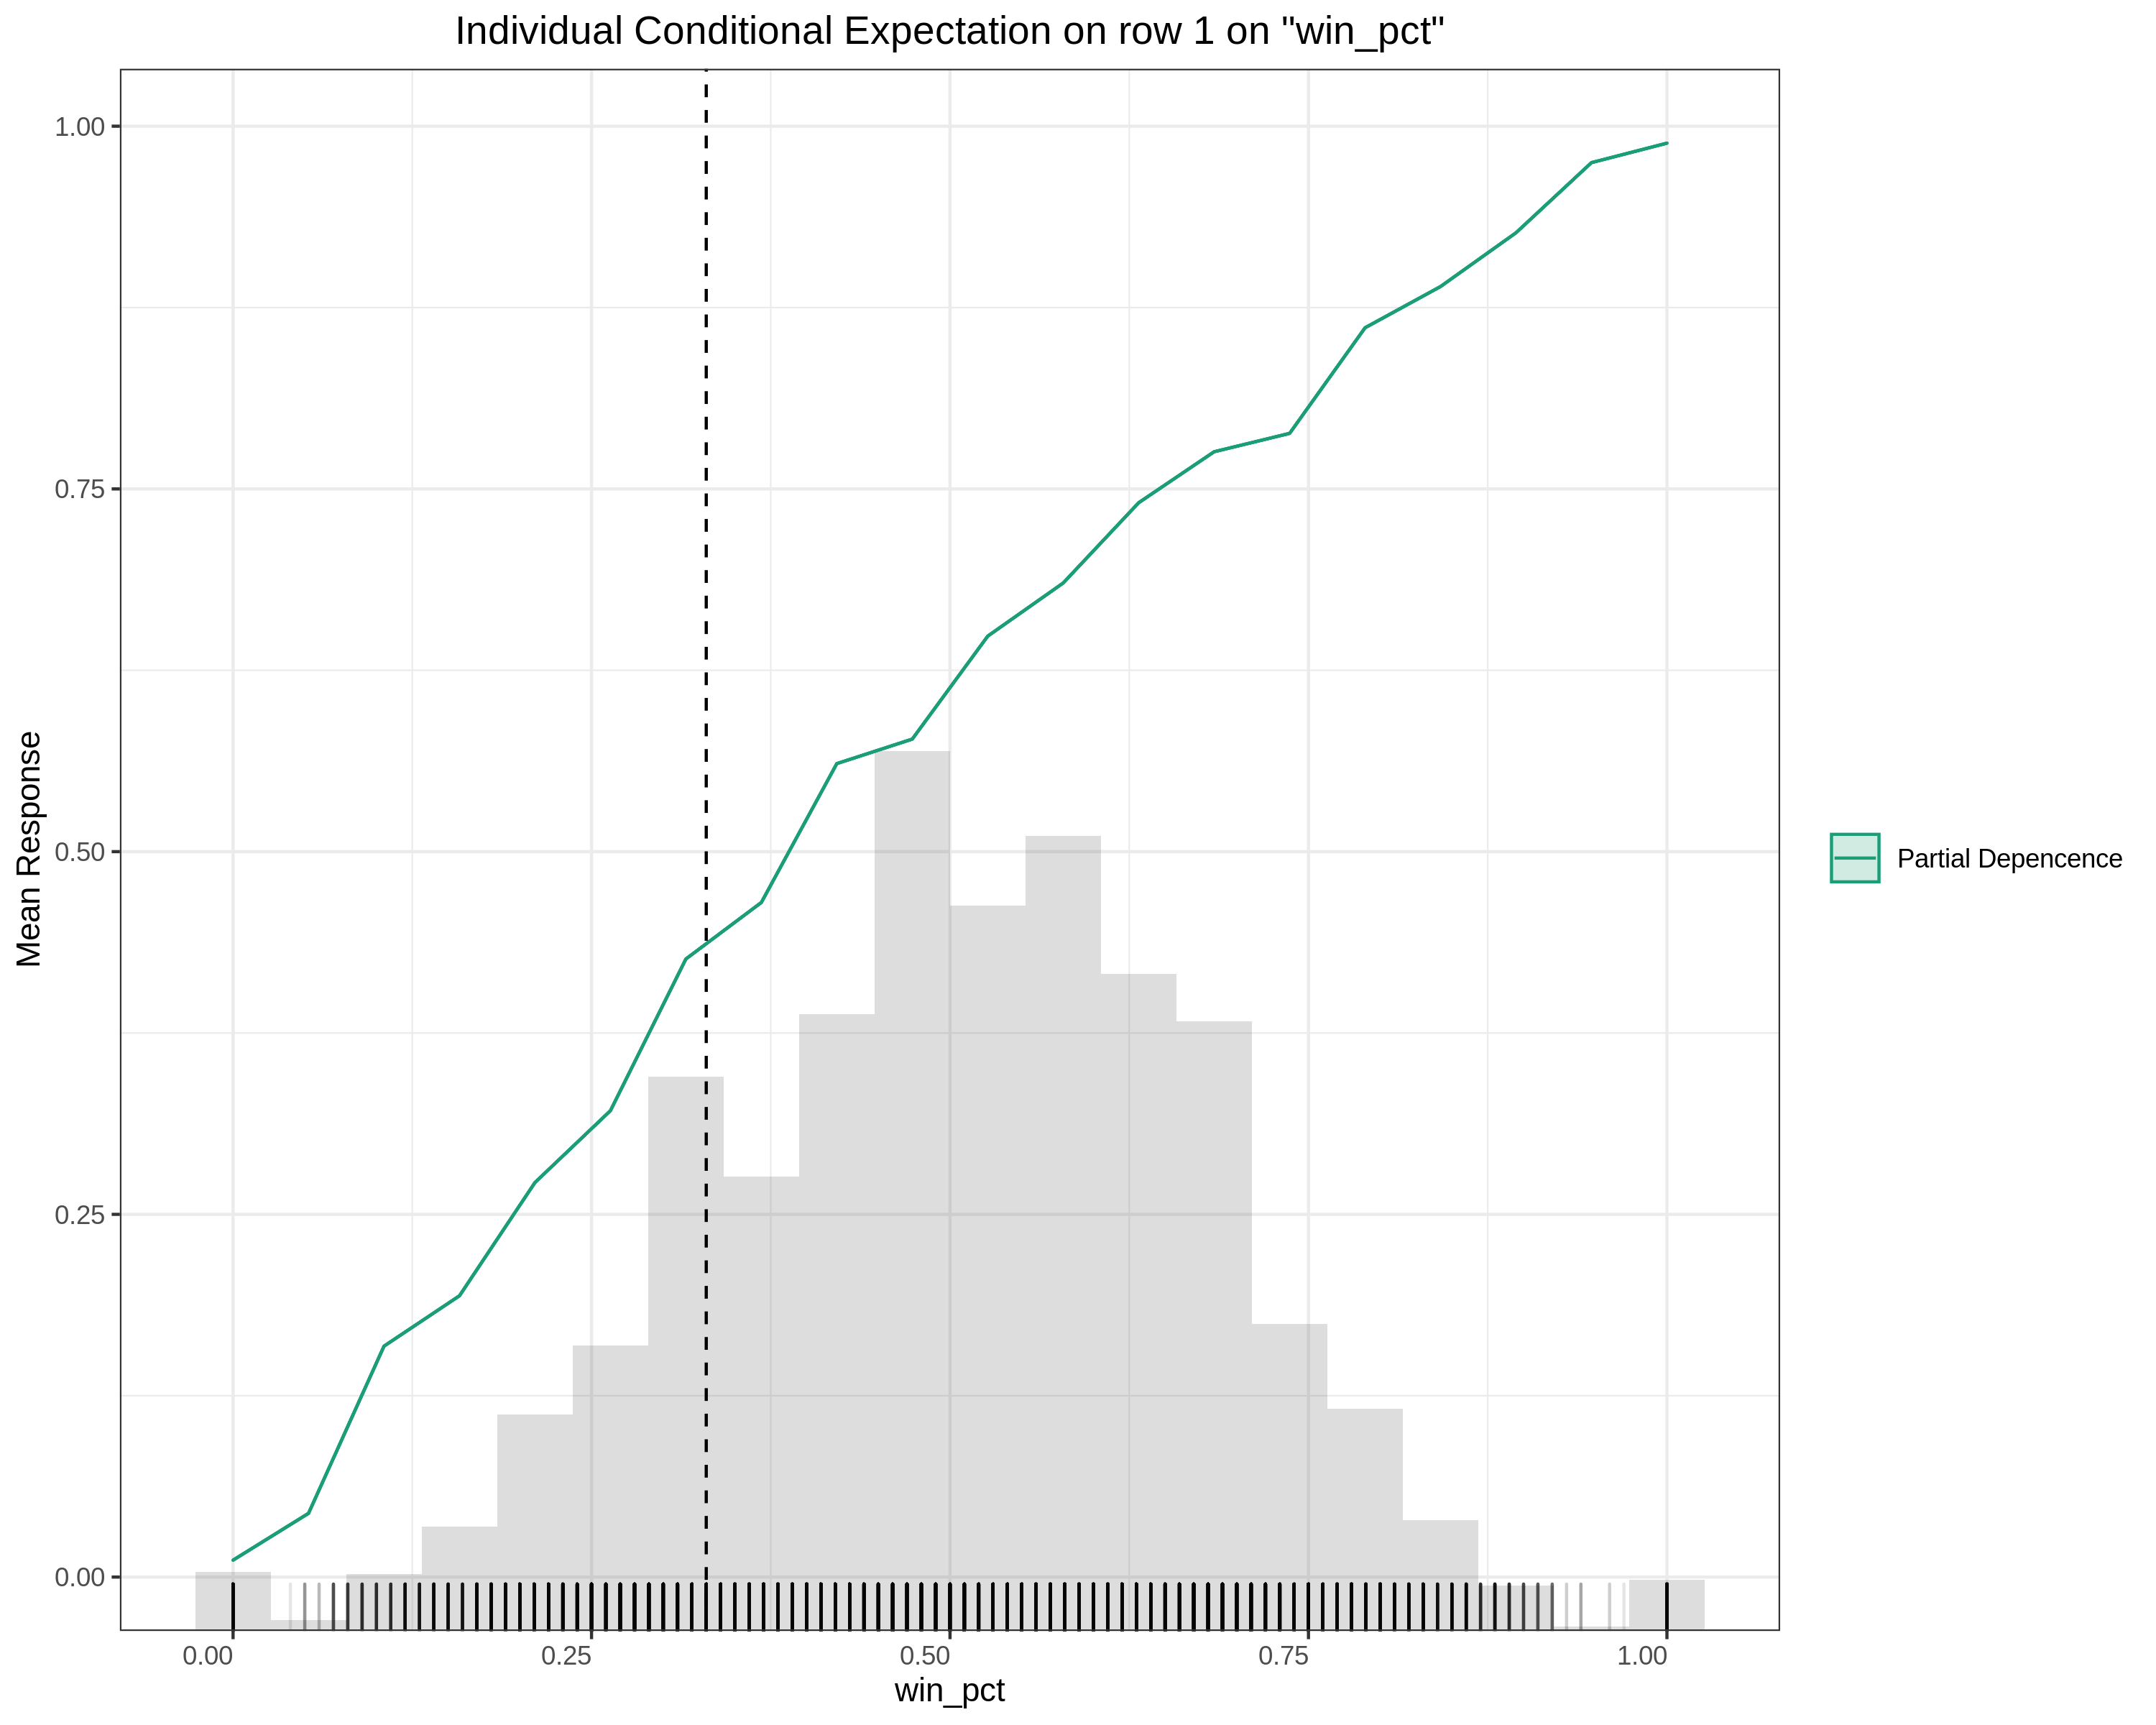

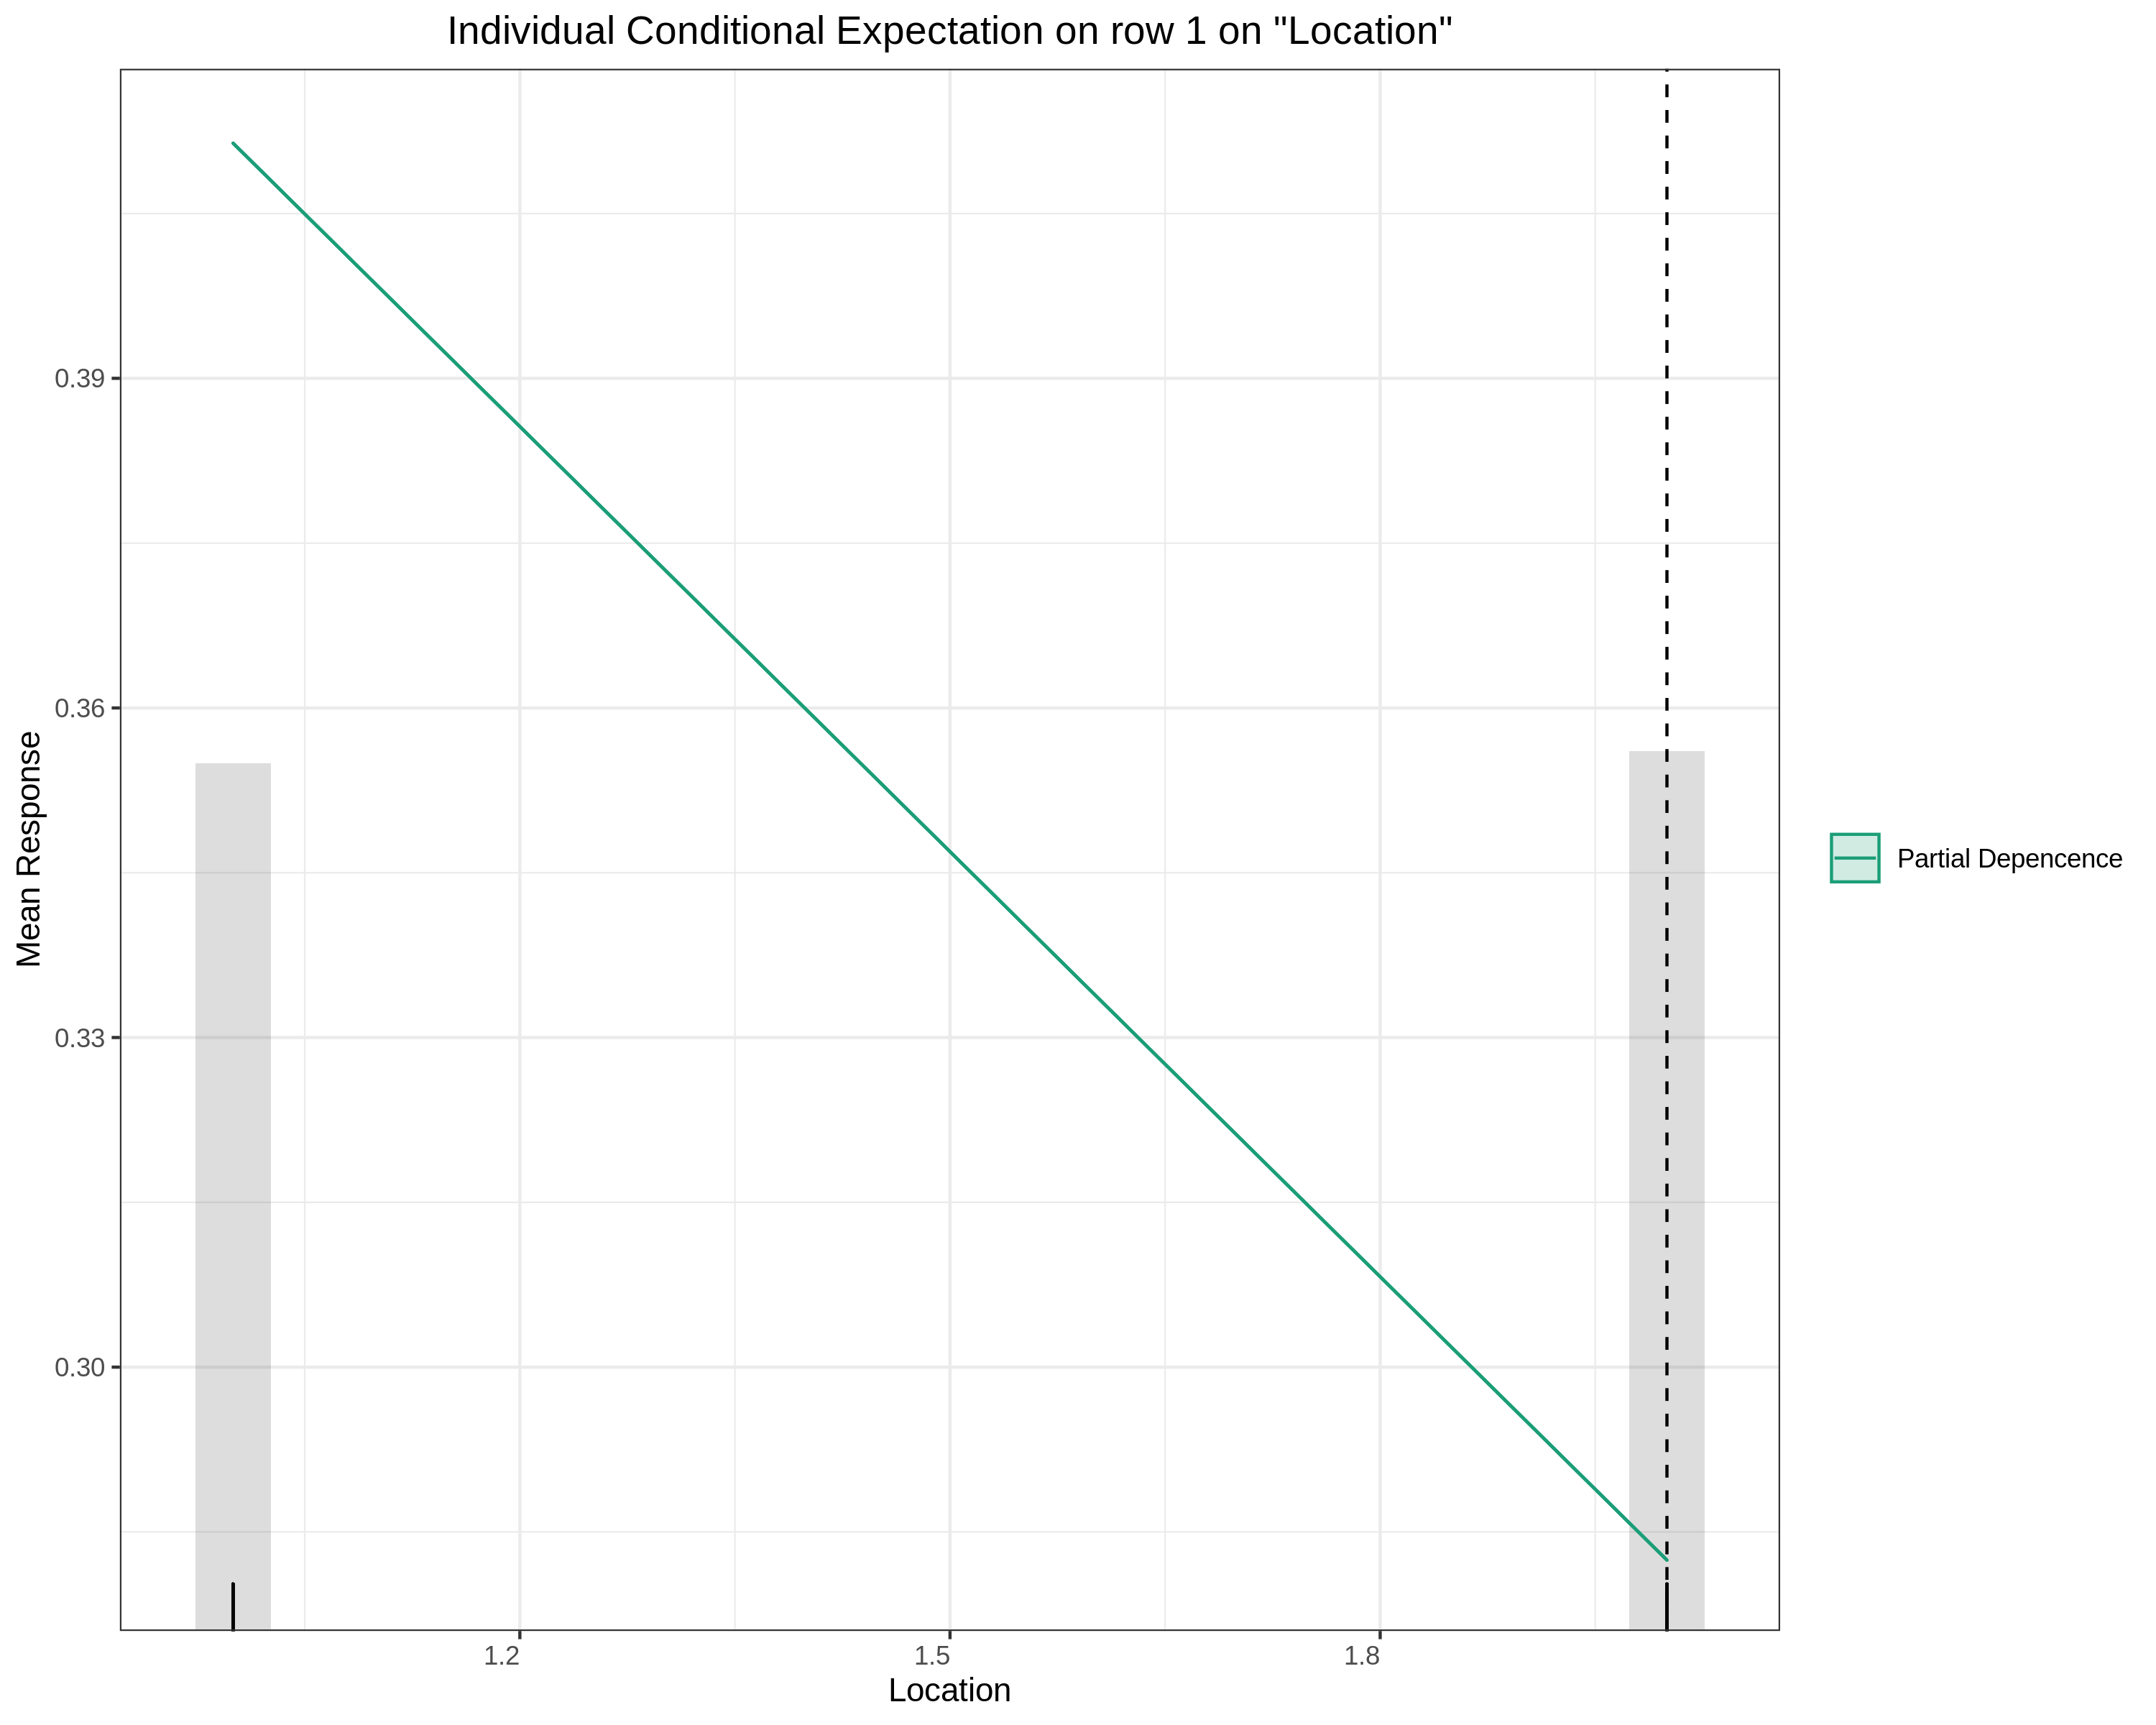

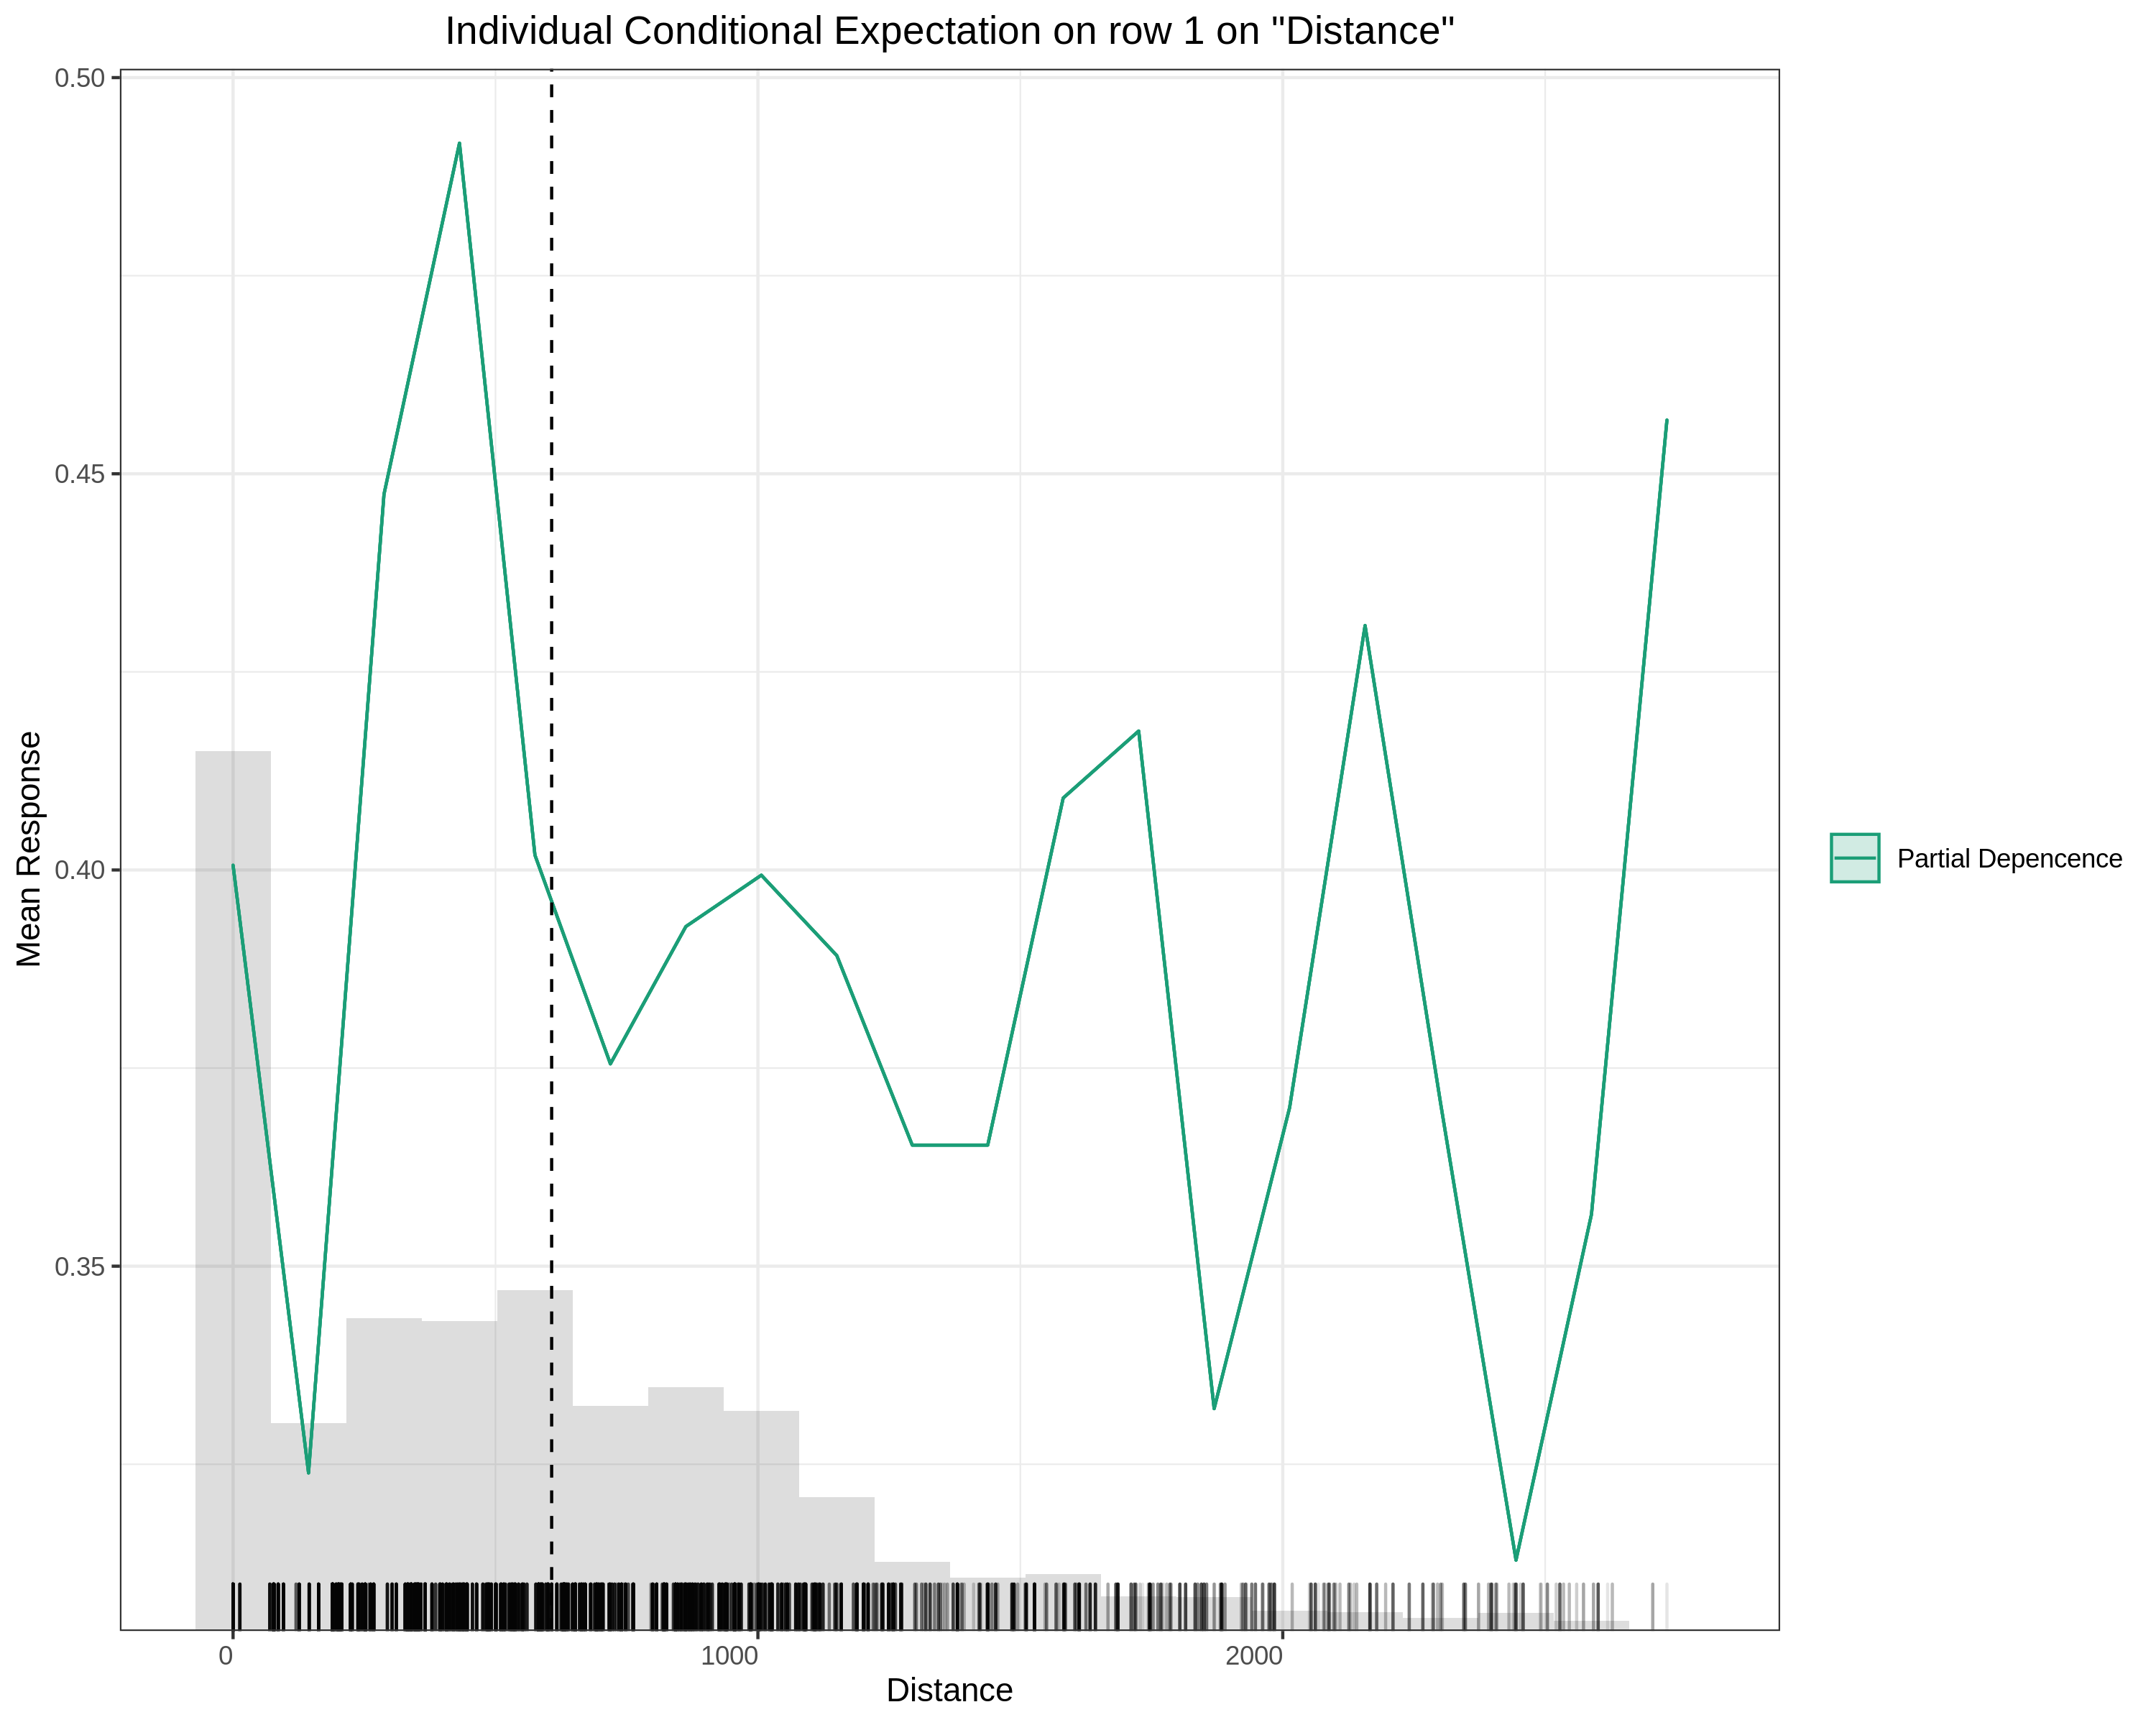

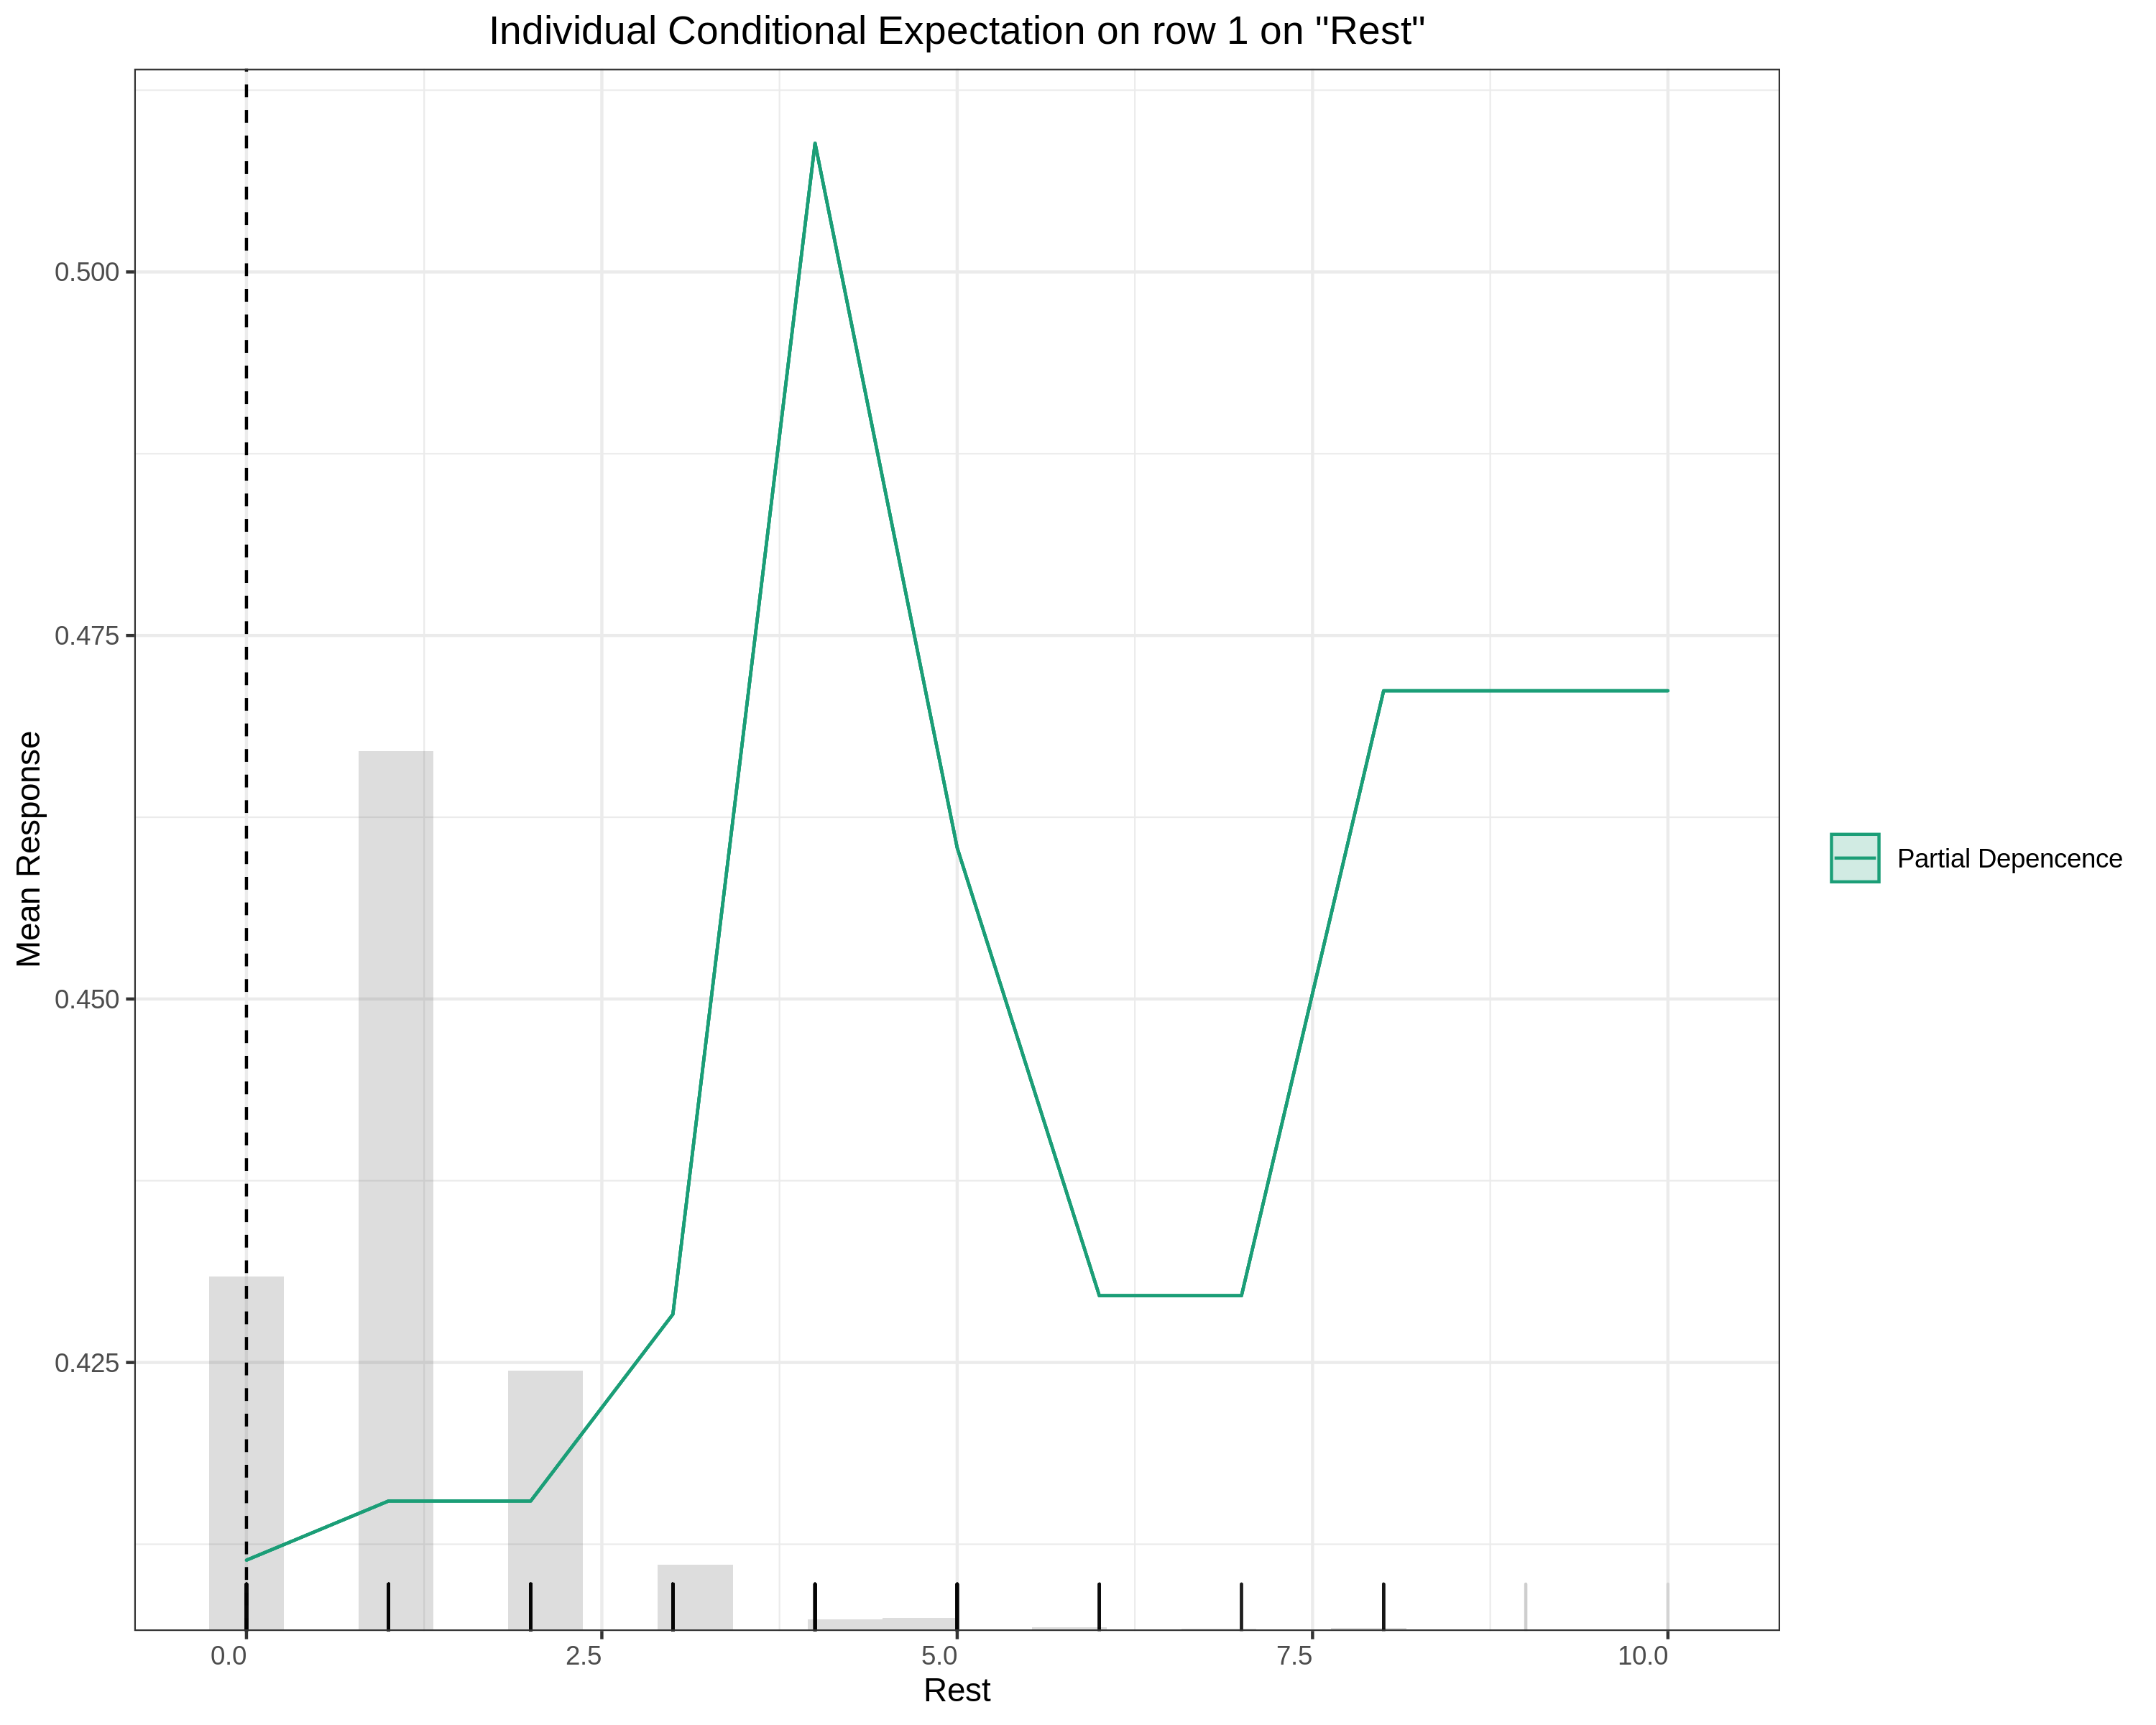

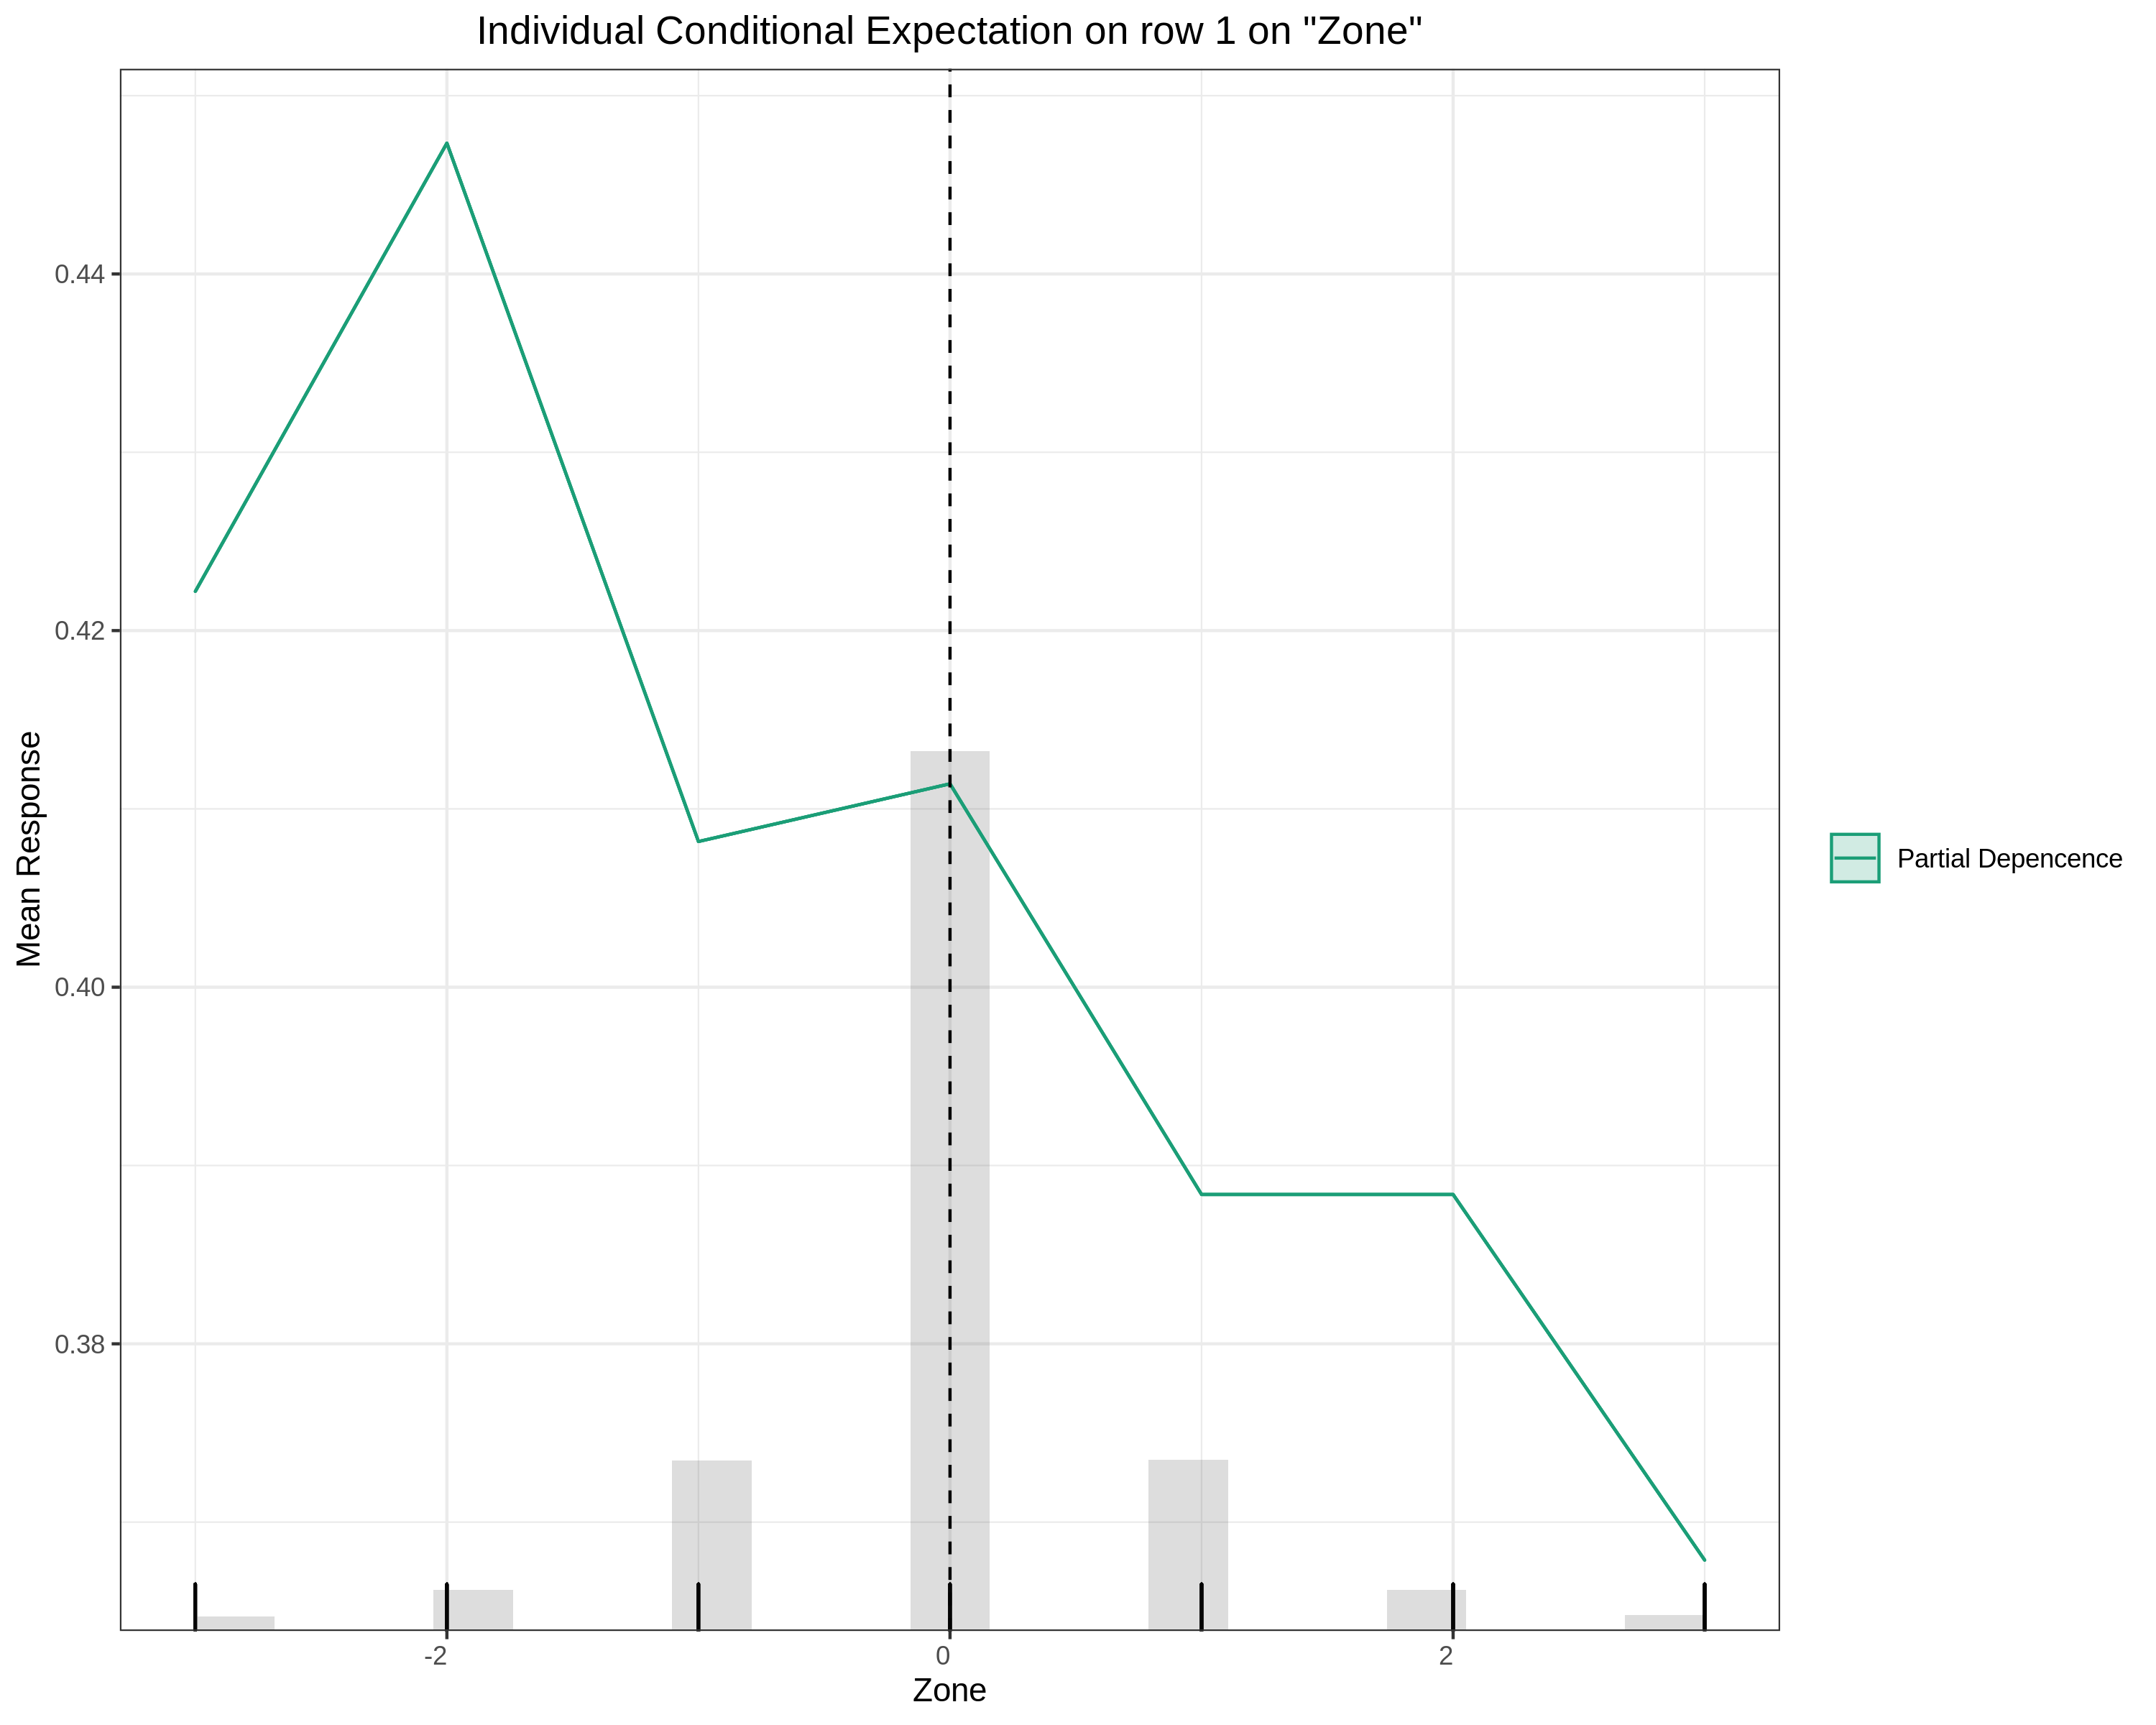

In [ ]:
#shap explanation for one observation, in this case I picked the first observation of the dataser
shap_ind_row <- h2o.shap_explain_row_plot(mod_xgb, h_test, row_index = 1)
print(explain_ind_row)

#observation one in the dataset corresponds to
# Season: 1999-00
# Phase: Regular Season
# Month: Nov
# Week: 44
# Date: 1999-11-02
# Team: Atlanta Hawks
# Opponent: Washington Wizards
# Location: Away
# Outcome: L
# City: Washington DC
# Miles Traveled: 544
# Route: Atlanta - Washington
# Rest Days: 15
# Time Zone: America/New_York
# Time Zone Change: 0hrs
# Direction of Travel: East (no time change)
# Win%: 0.00 (first game of the season)

In [ ]:
# Build several ml models for comparison. Added basic param. This could be further tuned to compare performance across models.
# This will take around 45-50mins with current specs. Adjust max_run_time for shorter times if needed
automl <- h2o.automl(x = features,
                    y = target,
                    training_frame = h_train,
                    nfolds = 5,     
                    max_models = 20,
                    stopping_metric = "logloss",
                    project_name = "automl_nba_schedule",
                    sort_metric = "logloss",
                    seed = 42)

  |======================================================================| 100%


In [ ]:
#create model leaderboard from all the above models
mod_leaderboard <- as.data.frame(automl@leaderboard) %>% 
mutate(logloss = round(logloss, 2),
       auc = round(auc,3),
       aucpr = round(aucpr,3),
       mean_per_class_error = round(mean_per_class_error,3),
       rmse = round(rmse,3),
       mse = round(mse,3))

# display leaderboard. (Top model is a GLM)
mod_leaderboard

# I won't go further into this but performance for each or all of the above models could be further assessed.

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLM_1_AutoML_20210331_124728,0.61,0.727,0.724,0.379,0.459,0.211
StackedEnsemble_AllModels_AutoML_20210331_124728,0.61,0.727,0.724,0.375,0.459,0.211
StackedEnsemble_BestOfFamily_AutoML_20210331_124728,0.61,0.727,0.724,0.372,0.459,0.211
GBM_1_AutoML_20210331_124728,0.61,0.725,0.720,0.369,0.460,0.211
DeepLearning_grid__1_AutoML_20210331_124728_model_1,0.61,0.725,0.722,0.376,0.460,0.211
DeepLearning_grid__2_AutoML_20210331_124728_model_1,0.61,0.726,0.722,0.379,0.460,0.211
XGBoost_3_AutoML_20210331_124728,0.61,0.724,0.719,0.376,0.460,0.212
GBM_2_AutoML_20210331_124728,0.61,0.723,0.718,0.373,0.460,0.212
XGBoost_grid__1_AutoML_20210331_124728_model_2,0.61,0.723,0.717,0.377,0.461,0.212
